In [1]:
#imports
import numba
import tensorflow as tf
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import random
from tqdm import tqdm
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors
from PIL import Image
import math

%matplotlib inline

### load train and test dataset + preprocess

In [2]:
# load train and test dataset
def load_dataset():
    # load dataset
    (trainX, trainY), (testX, testY) = mnist.load_data()
    # reshape dataset to have a single channel
    trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
    testX = testX.reshape((testX.shape[0], 28, 28, 1))
    # one hot encode target values
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    return trainX, trainY, testX, testY

trainX, trainY, testX, testY = load_dataset()

11493376/11490434 [==============================] - 0s 0us/step


In [3]:
# preprocess pixels
def preprocess_pixels(trainX, testX):
    # convert from integers to floats
    trainX_norm = trainX.astype('float32')
    testX_norm = testX.astype('float32')
    # normalize to range 0-1
    trainX_norm = trainX_norm / 255.0
    testX_norm = testX_norm / 255.0
    # return normalized images
    return trainX_norm, testX_norm

trainX, testX = preprocess_pixels(trainX, testX)
print("trainX shape ", trainX.shape, "testX shape ", testX.shape)

trainX shape  (60000, 28, 28, 1) testX shape  (10000, 28, 28, 1)


In [4]:
class kohonen():
  def __init__(self, x, y, alpha_init=0.6, gamma_init=None, max_iter = 300):
    # latent space dim
    self.x = x
    self.y = y

    self.nb_centroids = x * y

    self.alpha = alpha_init

    if gamma_init:
      self.gamma = gamma_init
    else:
      self.gamma = x / 2.

    self.centroids_w = []
    self.centroids_c = []


    self.max_iter = max_iter
    self.centroids = []

  def initialization(self, dataset):
    # initialization of w (random exemple)
    get_ids = []
    dims = []

    while len(self.centroids_w) < self.nb_centroids:
      r = random.randint(0, len(dataset)-1)
      if r in get_ids:
        continue
      get_ids.append(r)

      self.centroids_w.append(dataset[r])

    # initialisation of c (one centroid per cross int)
    for x in range(self.x):
      for y in range(self.y):
        dims.append((x,y))
    self.centroids_c = np.asarray(dims)


  def get_id_closest_centroid(self, Sj):
    id_closest = 0
    val_closest = np.linalg.norm(Sj - self.centroids_w[0])
    for i,centroid in enumerate(self.centroids_w):
      val = np.linalg.norm(Sj - centroid)
      if val <= val_closest:
        val_closest = val
        id_closest = i

    return id_closest


  def update_feature_vector(self, id_closest, id_centroid, Sj):

    norm = np.linalg.norm(self.centroids_c[id_centroid] - self.centroids_c[id_closest])

    return self.centroids_w[id_centroid] + self.alpha * (math.exp( -( norm / (2 * self.gamma) ) )) * (Sj - self.centroids_w[id_centroid])


  def fit(self, dataset, classes, print_plot_latency=100, batch_print_size=200, gamma=0.2):

    self.initialization(dataset)

    associate = [] 
    iterate = 0

    while iterate < self.max_iter:
      iterate += 1

      Sj = dataset[random.randint(0, len(dataset) - 1)]

      id_closest = self.get_id_closest_centroid(Sj)

      for i,centroid in enumerate(self.centroids_w):
        self.centroids_w[i] = self.update_feature_vector(id_closest, i, Sj)

      #if iterate % print_plot_latency == 0:
        #self.plot_graph(dataset, classes,batch_print_size, gamma)

    self.plot_histo(dataset, classes)

  def get_coordinate_for_example(self, point, gamma):
    
    x_sum = 0
    y_sum = 0

    for id_centroid,centroid in enumerate(self.centroids_c):
      norm = np.linalg.norm(point - centroid)
      p = math.exp( -( 1 / (2 * gamma) ) * norm)

      x_sum += (centroid[0] * p)
      y_sum += (centroid[1] * p)

    return x_sum, y_sum


  def plot_graph(self, dataset, classes, batch_print_size, gamma):

    plot_compress_trainX = []
    data = []
    id_class = []
    for i in range(batch_print_size):
      r = random.randint(0, len(dataset) - 1)
      data.append(dataset[r])
      id_class.append(np.argmax(classes[r]))
      
    for exemple in data:
      x,y = self.get_coordinate_for_example(exemple, gamma)


      plot_compress_trainX.append((x,y))

    ids_class = np.asarray(id_class)
    list_coord = np.asarray(plot_compress_trainX)


    print(ids_class.shape)
    print(type(ids_class[0]))
    print(list_coord.shape)
    print(type(list_coord[0]))

    plt.figure(figsize=(12, 12))
    plt.scatter(list_coord[:,0], list_coord[:,1], c=ids_class, s=5)
    plt.colorbar()
    plt.xlabel('X')
    plt.ylabel('Y')


  def plot_centroids(self):

    digit_size = 28
    #prepare the figure
    figure = np.zeros((digit_size * x, digit_size * y))
    #take figure_size points in range [0, 35] standard deviations for x and [0, 20] for y
    grid_x = np.linspace(0, 50, x)
    grid_y = np.linspace(0, 25, y)

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.array([[xi, yi]])
            x_decoded = my_autoencoder.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    plt.imshow(figure)
    plt.show()


  def plot_histo(self, dataset, classes):
        class0 = [0]*self.nb_centroids
        class1 = [0]*self.nb_centroids
        class2 = [0]*self.nb_centroids
        class3 = [0]*self.nb_centroids
        class4 = [0]*self.nb_centroids
        class5 = [0]*self.nb_centroids
        class6 = [0]*self.nb_centroids
        class7 = [0]*self.nb_centroids
        class8 = [0]*self.nb_centroids
        class9 = [0]*self.nb_centroids
        x_list = []

        for id in range(self.nb_centroids):
          x_list.append(id + 1)
          for img_id,img in enumerate(dataset):
            if id == self.get_id_closest_centroid(img):
              if np.where(classes[img_id] == 1.0)[0][0] == 0:
                class0[id]+=1
              elif np.where(classes[img_id] == 1.0)[0][0] == 1:
                class1[id]+=1
              elif np.where(classes[img_id] == 1.0)[0][0] == 2:
                class2[id]+=1
              elif np.where(classes[img_id] == 1.0)[0][0] == 3:
                class3[id]+=1
              elif np.where(classes[img_id] == 1.0)[0][0] == 4:
                class4[id]+=1
              elif np.where(classes[img_id] == 1.0)[0][0] == 5:
                class5[id]+=1
              elif np.where(classes[img_id] == 1.0)[0][0] == 6:
                class6[id]+=1
              elif np.where(classes[img_id] == 1.0)[0][0] == 7:
                class7[id]+=1
              elif np.where(classes[img_id] == 1.0)[0][0] == 8:
                class8[id]+=1
              else:
                class9[id]+=1

        x = np.asarray(x_list)
        plt.figure(figsize=(20, 8))
        width = 0.09

        plt.bar(x-0.45, class1, width=0.09, color='blue', align='center',label="1")
        plt.bar(x-0.36, class2, width=0.09, color='orange', align='center',label="2")
        plt.bar(x-0.27, class3, width=0.09, color='green', align='center',label="3")
        plt.bar(x-0.18, class4, width=0.09, color='red', align='center',label="4")
        plt.bar(x-0.09, class5, width=0.09, color='purple', align='center',label="5")
        plt.bar(x, class6, width=0.09, color='brown', align='center',label="6")
        plt.bar(x+0.09, class7, width=0.09, color='pink', align='center',label="7")
        plt.bar(x+0.18, class8, width=0.09, color='grey', align='center',label="8")
        plt.bar(x+0.27, class9, width=0.09, color='olive', align='center',label="9")
        plt.bar(x+0.36, class0, width=0.09, color='cyan', align='center',label="0")

        plt.xlabel("id_centroid")
        plt.ylabel("number of data")
        plt.title("Number data per classes per centroids")

        plt.xticks(x + width/2, x)
        plt.legend()

        plt.show()

  def simple_encode(self, X):
    val_closest = np.linalg.norm(X - self.centroids_w[0])
    id_closest = 0
    for i,centroid in tqdm(enumerate(self.centroids_w)):
      val = np.linalg.norm(X - centroid)
      if val <= val_closest:
        val_closest = val
        id_closest = i

    return self.centroids_c[id_closest]

  def simple_decode(self, X_encode):
    id_result = 0
    for id,centroid in enumerate(self.centroids_c):
      if centroid[0] == X_encode[0] and centroid[1] == X_encode[1]:
        id_result = id
    return self.centroids_w[id_result]

  def print_centroids_as_imgs(self):
    x = 0
    y = 0
    fig=plt.figure(figsize=(10, 10))
    columns = self.x
    rows = self.y

    for id,centroid in enumerate(self.centroids_c):
      fig.add_subplot(rows, columns, id)
      plt.imshow(centroids_w[id], cmap=plt.cm.binary)
      plt.xlabel(id)

In [5]:
test1 = kohonen(1,1,alpha_init=0.6,gamma_init=0.1,max_iter=5000)
test2 = kohonen(2,2,alpha_init=0.6,gamma_init=0.1,max_iter=5000)
test3 = kohonen(3,3,alpha_init=0.6,gamma_init=0.1,max_iter=5000)
test4 = kohonen(4,4,alpha_init=0.6,gamma_init=0.1,max_iter=5000)
test5 = kohonen(5,5,alpha_init=0.6,gamma_init=0.1,max_iter=5000)
test6 = kohonen(4,4,alpha_init=0.3,gamma_init=0.1,max_iter=5000)
test7 = kohonen(5,5,alpha_init=0.3,gamma_init=0.1,max_iter=5000)
test8 = kohonen(4,4,alpha_init=0.6,gamma_init=0.01,max_iter=5000)
test9 = kohonen(5,5,alpha_init=0.6,gamma_init=0.01,max_iter=5000)
test10 = kohonen(4,4,alpha_init=0.3,gamma_init=0.01,max_iter=5000)
test11 = kohonen(5,5,alpha_init=0.3,gamma_init=0.01,max_iter=5000)
test12 = kohonen(4,4,alpha_init=0.3,gamma_init=0.01,max_iter=50000)
test13 = kohonen(5,5,alpha_init=0.3,gamma_init=0.01,max_iter=50000)

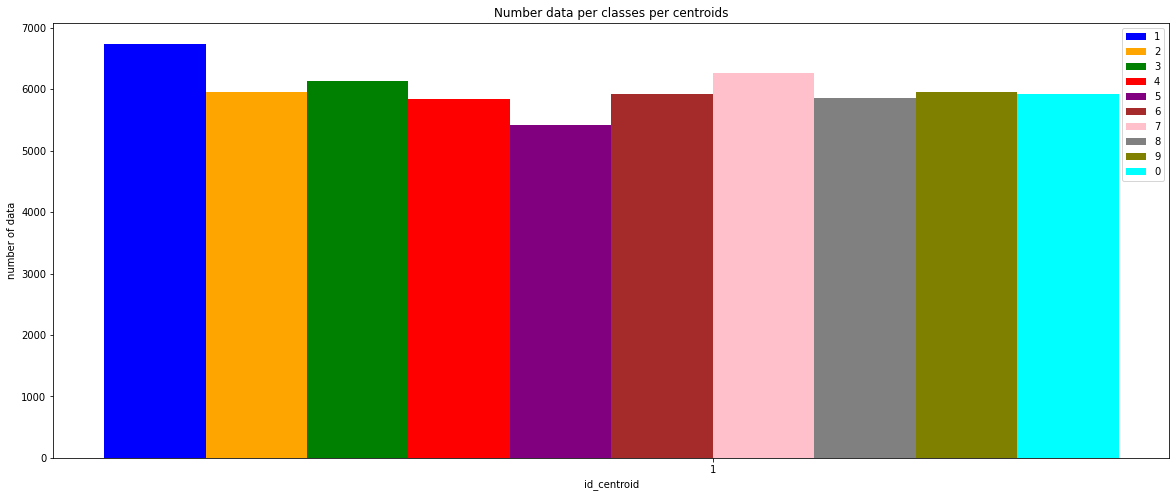

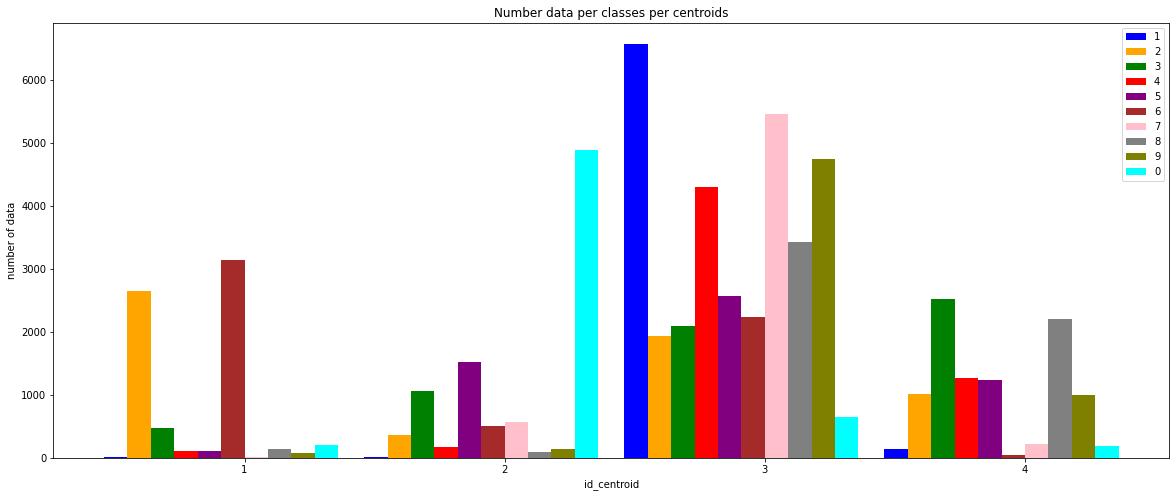

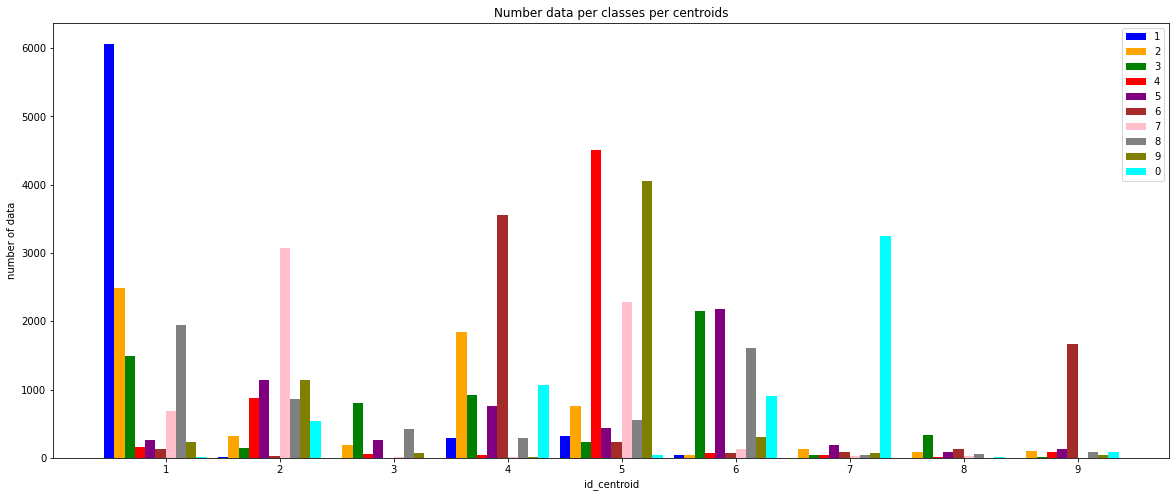

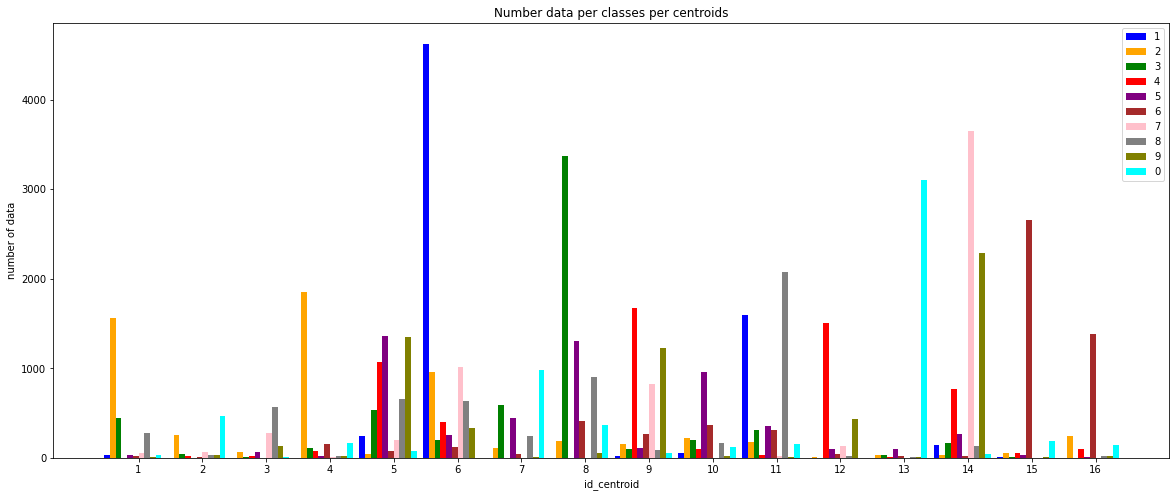

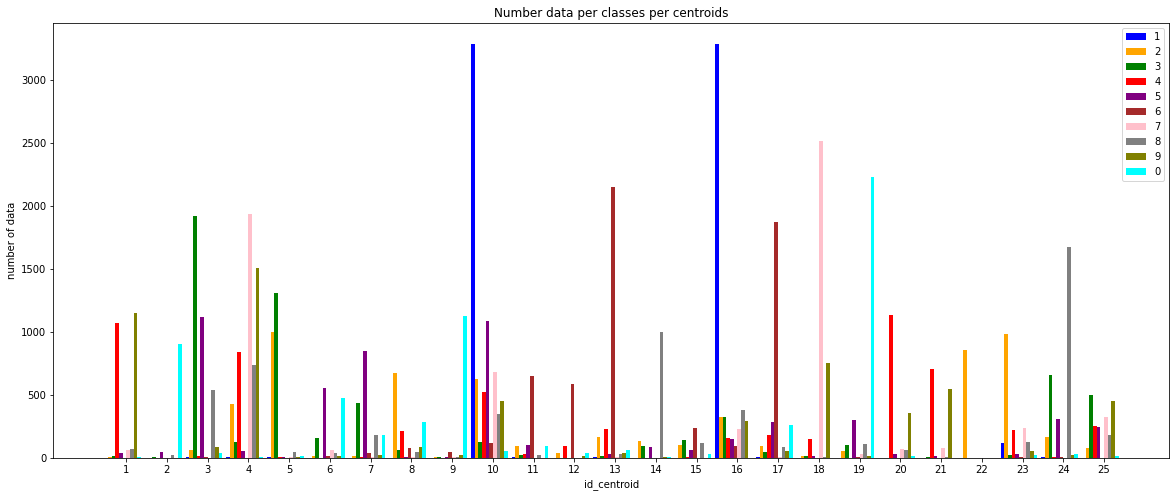

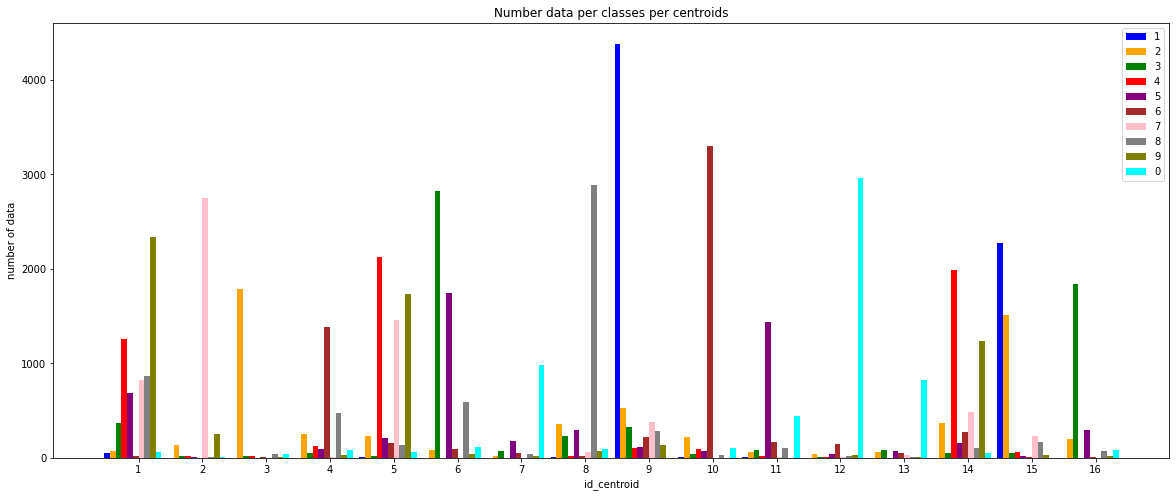

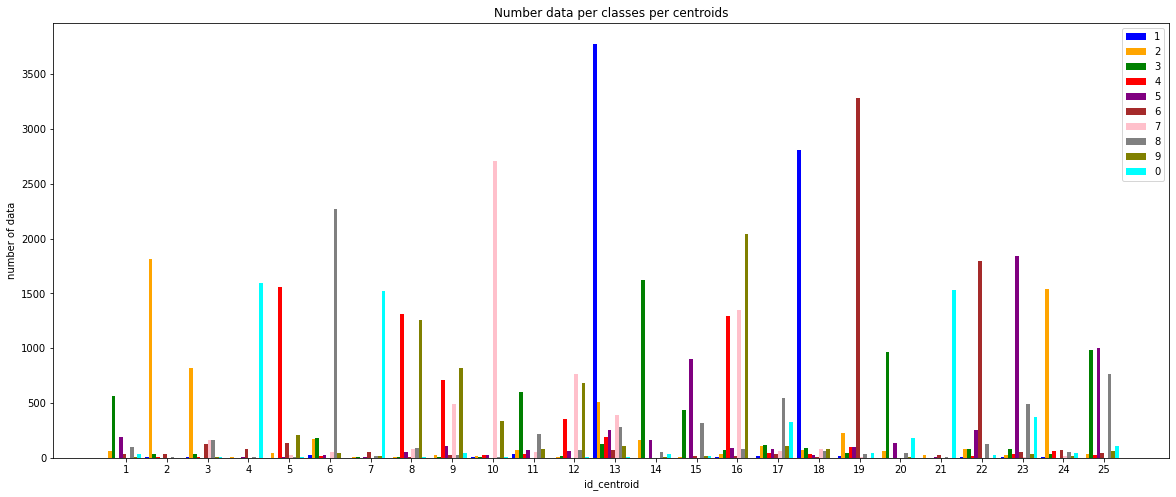

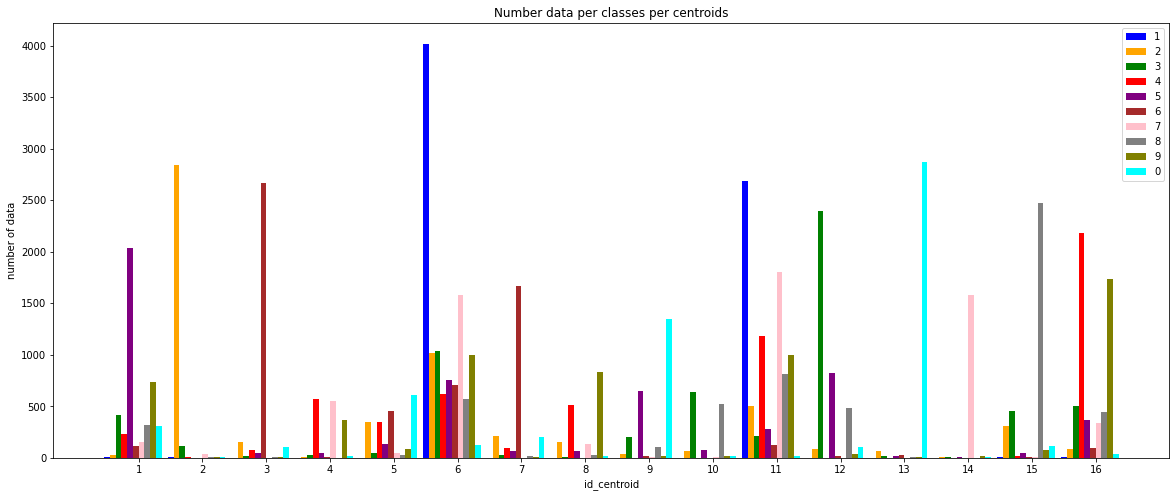

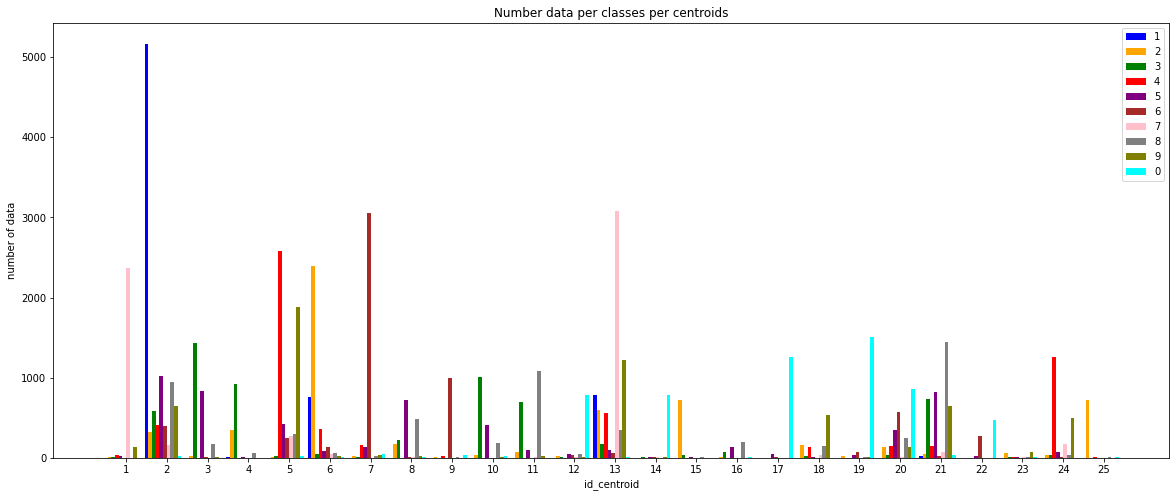

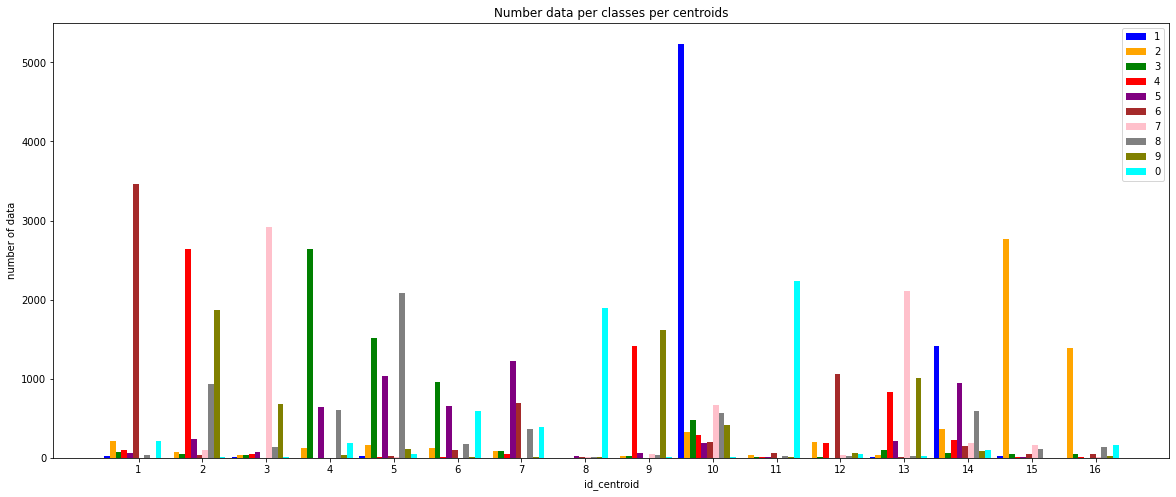

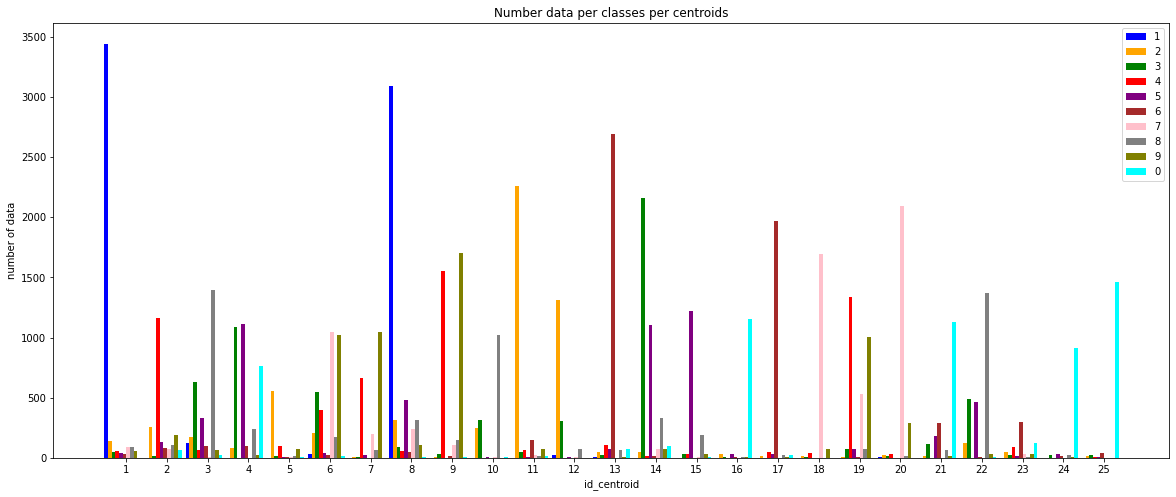

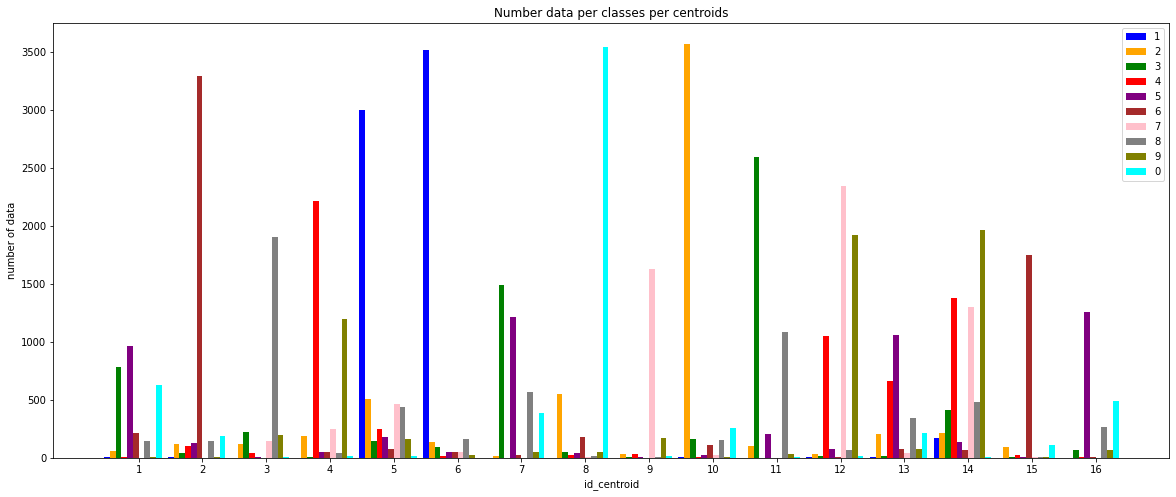

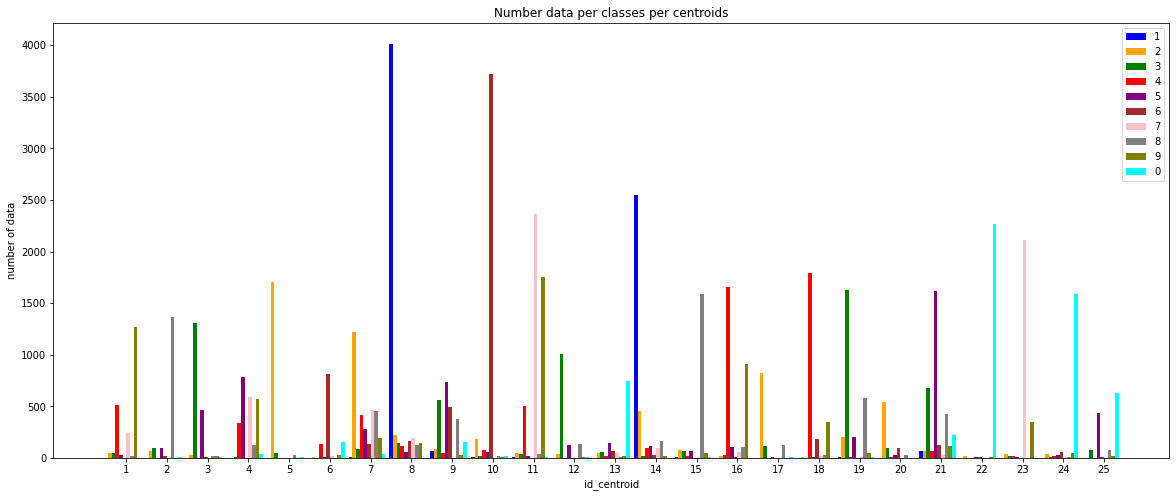

In [6]:
test1.fit(dataset=trainX, classes=trainY, print_plot_latency=100,batch_print_size=200,gamma=0.2)
test2.fit(dataset=trainX, classes=trainY, print_plot_latency=100,batch_print_size=200,gamma=0.2)
test3.fit(dataset=trainX, classes=trainY, print_plot_latency=100,batch_print_size=200,gamma=0.2)
test4.fit(dataset=trainX, classes=trainY, print_plot_latency=100,batch_print_size=200,gamma=0.2)
test5.fit(dataset=trainX, classes=trainY, print_plot_latency=100,batch_print_size=200,gamma=0.2)
test6.fit(dataset=trainX, classes=trainY, print_plot_latency=100,batch_print_size=200,gamma=0.2)
test7.fit(dataset=trainX, classes=trainY, print_plot_latency=100,batch_print_size=200,gamma=0.2)
test8.fit(dataset=trainX, classes=trainY, print_plot_latency=100,batch_print_size=200,gamma=0.2)
test9.fit(dataset=trainX, classes=trainY, print_plot_latency=100,batch_print_size=200,gamma=0.2)
test10.fit(dataset=trainX, classes=trainY, print_plot_latency=100,batch_print_size=200,gamma=0.2)
test11.fit(dataset=trainX, classes=trainY, print_plot_latency=100,batch_print_size=200,gamma=0.2)
test12.fit(dataset=trainX, classes=trainY, print_plot_latency=100,batch_print_size=200,gamma=0.2)
test13.fit(dataset=trainX, classes=trainY, print_plot_latency=100,batch_print_size=200,gamma=0.2)

1it [00:00, 1132.98it/s]
4it [00:00, 839.11it/s]
9it [00:00, 1961.58it/s]
16it [00:00, 32341.62it/s]
25it [00:00, 8999.88it/s]
16it [00:00, 3774.61it/s]
25it [00:00, 3595.45it/s]
16it [00:00, 3459.75it/s]
25it [00:00, 2783.21it/s]
16it [00:00, 8655.86it/s]
25it [00:00, 30977.13it/s]
16it [00:00, 14797.99it/s]
25it [00:00, 8485.00it/s]


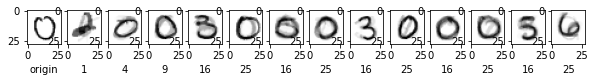

1it [00:00, 297.72it/s]
4it [00:00, 1142.47it/s]
9it [00:00, 2291.27it/s]
16it [00:00, 5472.91it/s]
25it [00:00, 4369.98it/s]
16it [00:00, 9613.07it/s]
25it [00:00, 2998.76it/s]
16it [00:00, 4400.58it/s]
25it [00:00, 4948.21it/s]
16it [00:00, 4104.77it/s]
25it [00:00, 6064.64it/s]
16it [00:00, 3723.93it/s]
25it [00:00, 4321.35it/s]


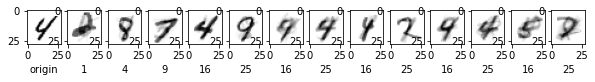

1it [00:00, 189.12it/s]
4it [00:00, 890.60it/s]
9it [00:00, 9054.63it/s]
16it [00:00, 11552.57it/s]
25it [00:00, 5848.17it/s]
16it [00:00, 2941.18it/s]
25it [00:00, 7819.94it/s]
16it [00:00, 24726.92it/s]
25it [00:00, 44753.56it/s]
16it [00:00, 2921.21it/s]
25it [00:00, 4766.04it/s]
16it [00:00, 26265.70it/s]
25it [00:00, 6254.55it/s]


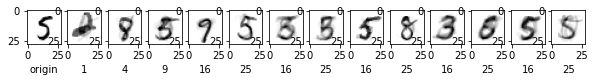

1it [00:00, 231.07it/s]
4it [00:00, 1230.81it/s]
9it [00:00, 2488.87it/s]
16it [00:00, 27846.00it/s]
25it [00:00, 8093.99it/s]
16it [00:00, 4945.38it/s]
25it [00:00, 9232.05it/s]
16it [00:00, 2324.36it/s]
25it [00:00, 9525.58it/s]
16it [00:00, 8309.67it/s]
25it [00:00, 11377.78it/s]
16it [00:00, 8931.18it/s]
25it [00:00, 6294.73it/s]


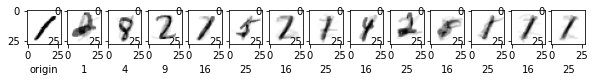

1it [00:00, 1308.27it/s]
4it [00:00, 1617.70it/s]
9it [00:00, 6928.92it/s]
16it [00:00, 2786.22it/s]
25it [00:00, 3745.18it/s]
16it [00:00, 3159.40it/s]
25it [00:00, 13164.80it/s]
16it [00:00, 8620.28it/s]
25it [00:00, 4678.01it/s]
16it [00:00, 28363.85it/s]
25it [00:00, 6585.29it/s]
16it [00:00, 3822.78it/s]
25it [00:00, 8631.68it/s]


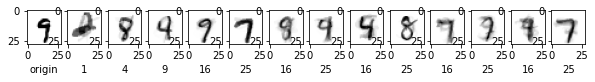

1it [00:00, 308.59it/s]
4it [00:00, 1705.00it/s]
9it [00:00, 2803.05it/s]
16it [00:00, 2983.81it/s]
25it [00:00, 8993.70it/s]
16it [00:00, 2623.49it/s]
25it [00:00, 3773.21it/s]
16it [00:00, 29127.11it/s]
25it [00:00, 3921.08it/s]
16it [00:00, 4721.99it/s]
25it [00:00, 3487.81it/s]
16it [00:00, 5465.78it/s]
25it [00:00, 8059.15it/s]


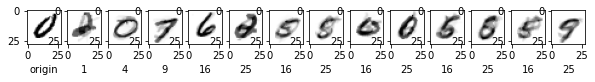

1it [00:00, 3435.14it/s]
4it [00:00, 1758.62it/s]
9it [00:00, 1806.85it/s]
16it [00:00, 2816.39it/s]
25it [00:00, 36120.43it/s]
16it [00:00, 4885.26it/s]
25it [00:00, 10232.01it/s]
16it [00:00, 5844.70it/s]
25it [00:00, 30840.47it/s]
16it [00:00, 21379.06it/s]
25it [00:00, 23479.09it/s]
16it [00:00, 5476.93it/s]
25it [00:00, 9834.70it/s]


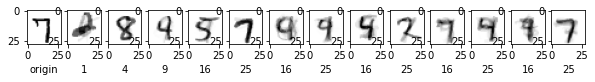

1it [00:00, 637.14it/s]
4it [00:00, 960.23it/s]
9it [00:00, 10120.30it/s]
16it [00:00, 6024.68it/s]
25it [00:00, 7525.31it/s]
16it [00:00, 2254.09it/s]
25it [00:00, 10122.37it/s]
16it [00:00, 8101.02it/s]
25it [00:00, 20313.37it/s]
16it [00:00, 4995.82it/s]
25it [00:00, 36058.32it/s]
16it [00:00, 2102.28it/s]
25it [00:00, 3987.74it/s]


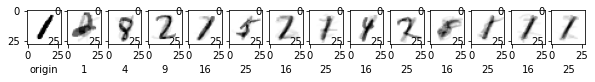

1it [00:00, 144.54it/s]
4it [00:00, 3880.02it/s]
9it [00:00, 3874.84it/s]
16it [00:00, 2171.25it/s]
25it [00:00, 34122.23it/s]
16it [00:00, 3846.66it/s]
25it [00:00, 4367.25it/s]
16it [00:00, 2314.42it/s]
25it [00:00, 33015.62it/s]
16it [00:00, 5839.62it/s]
25it [00:00, 3193.08it/s]
16it [00:00, 3624.18it/s]
25it [00:00, 3937.57it/s]


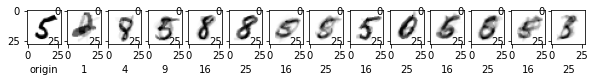

1it [00:00, 125.72it/s]
4it [00:00, 530.00it/s]
9it [00:00, 1138.90it/s]
16it [00:00, 23654.87it/s]
25it [00:00, 7027.99it/s]
16it [00:00, 5310.51it/s]
25it [00:00, 12178.58it/s]
16it [00:00, 14441.33it/s]
25it [00:00, 31813.59it/s]
16it [00:00, 29641.72it/s]
25it [00:00, 31300.78it/s]
16it [00:00, 27892.30it/s]
25it [00:00, 21968.91it/s]


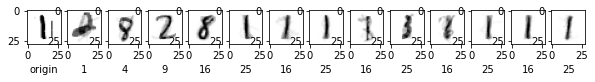

In [7]:
for i in range(10):
  fig=plt.figure(figsize=(10, 10))
  columns = 14
  rows = 1

  r = random.randint(0, len(testX))

  fig.add_subplot(rows, columns, 1) 
  plt.imshow(testX[r].squeeze(2), cmap=plt.cm.binary) # image orginal
  plt.xlabel("origin")

  fig.add_subplot(rows, columns, 2)
  plt.imshow(test1.simple_decode(test1.simple_encode(testX[r])).squeeze(2), cmap=plt.cm.binary)
  plt.xlabel(test1.nb_centroids)

  fig.add_subplot(rows, columns, 3)
  plt.imshow(test2.simple_decode(test2.simple_encode(testX[r])).squeeze(2), cmap=plt.cm.binary)
  plt.xlabel(test2.nb_centroids)

  fig.add_subplot(rows, columns, 4)
  plt.imshow(test3.simple_decode(test3.simple_encode(testX[r])).squeeze(2), cmap=plt.cm.binary)
  plt.xlabel(test3.nb_centroids)

  fig.add_subplot(rows, columns, 5)
  plt.imshow(test4.simple_decode(test4.simple_encode(testX[r])).squeeze(2), cmap=plt.cm.binary)
  plt.xlabel(test4.nb_centroids)

  fig.add_subplot(rows, columns, 6)
  plt.imshow(test5.simple_decode(test5.simple_encode(testX[r])).squeeze(2), cmap=plt.cm.binary)
  plt.xlabel(test5.nb_centroids)

  fig.add_subplot(rows, columns, 7)
  plt.imshow(test6.simple_decode(test6.simple_encode(testX[r])).squeeze(2), cmap=plt.cm.binary)
  plt.xlabel(test6.nb_centroids)
  
  fig.add_subplot(rows, columns, 8)
  plt.imshow(test7.simple_decode(test7.simple_encode(testX[r])).squeeze(2), cmap=plt.cm.binary)
  plt.xlabel(test7.nb_centroids)
  
  fig.add_subplot(rows, columns, 9)
  plt.imshow(test8.simple_decode(test8.simple_encode(testX[r])).squeeze(2), cmap=plt.cm.binary)
  plt.xlabel(test8.nb_centroids)
  
  fig.add_subplot(rows, columns, 10)
  plt.imshow(test9.simple_decode(test9.simple_encode(testX[r])).squeeze(2), cmap=plt.cm.binary)
  plt.xlabel(test9.nb_centroids)
  
  fig.add_subplot(rows, columns, 11)
  plt.imshow(test10.simple_decode(test10.simple_encode(testX[r])).squeeze(2), cmap=plt.cm.binary)
  plt.xlabel(test10.nb_centroids)
  
  fig.add_subplot(rows, columns, 12)
  plt.imshow(test11.simple_decode(test11.simple_encode(testX[r])).squeeze(2), cmap=plt.cm.binary)
  plt.xlabel(test11.nb_centroids)
  
  fig.add_subplot(rows, columns, 13)
  plt.imshow(test12.simple_decode(test12.simple_encode(testX[r])).squeeze(2), cmap=plt.cm.binary)
  plt.xlabel(test12.nb_centroids)
  
  fig.add_subplot(rows, columns, 14)
  plt.imshow(test13.simple_decode(test13.simple_encode(testX[r])).squeeze(2), cmap=plt.cm.binary)
  plt.xlabel(test13.nb_centroids)

  plt.show()